## 1. 데이터 준비하기

In [1]:
import os

data_path = os.getenv('HOME')+'/aiffel/conditional_generation/cityscapes/train/'
print("number of train examples :", len(os.listdir(data_path)))

number of train examples : 1000


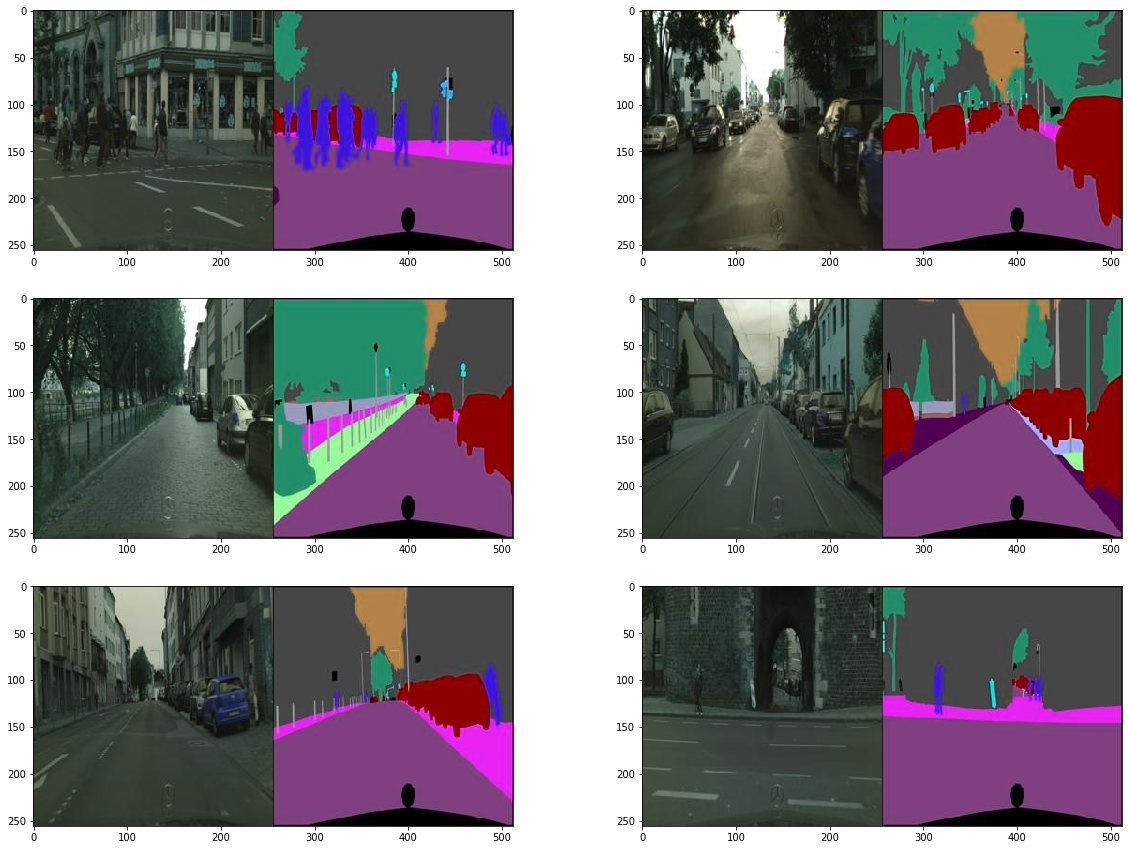

In [2]:
# 임의로 6장을 선택해 시각화
import cv2
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(20,15))
for i in range(1, 7):
    f = data_path + os.listdir(data_path)[np.random.randint(800)]
    img = cv2.imread(f, cv2.IMREAD_COLOR)
    plt.subplot(3,2,i)
    plt.imshow(img)

In [3]:
#이미지의 크기 확인
f = data_path + os.listdir(data_path)[0]
img = cv2.imread(f, cv2.IMREAD_COLOR)
print(img.shape)

(256, 512, 3)


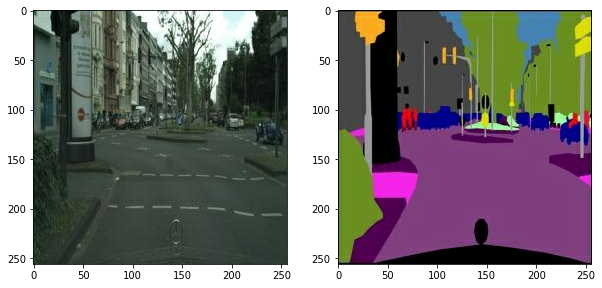

In [4]:
# (256, 512, 3) -> (256,256,3) * 2로 이미지 분할
import tensorflow as tf

def normalize(x):
    x = tf.cast(x, tf.float32)
    return (x/127.5) - 1

def denormalize(x):
    x = (x+1)*127.5
    x = x.numpy()
    return x.astype(np.uint8)

def load_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, 3)
    
    w = tf.shape(img)[1] // 2
    sketch = img[:, :w, :] 
    sketch = tf.cast(sketch, tf.float32)
    colored = img[:, w:, :] 
    colored = tf.cast(colored, tf.float32)
    return normalize(sketch), normalize(colored)

f = data_path + os.listdir(data_path)[1]
sketch, colored = load_img(f)

plt.figure(figsize=(10,7))
plt.subplot(1,2,1); plt.imshow(denormalize(sketch))
plt.subplot(1,2,2); plt.imshow(denormalize(colored))

In [5]:
# 학습에 사용하는 데이터의 다양성을 높이기 위해 argumentation 적용
from tensorflow import image
from tensorflow.keras.preprocessing.image import random_rotation

@tf.function() # 빠른 텐서플로 연산을 위해 @tf.function()을 사용합니다. 
def apply_augmentation(sketch, colored):
    stacked = tf.concat([sketch, colored], axis=-1)
    
    _pad = tf.constant([[30,30],[30,30],[0,0]])
    if tf.random.uniform(()) < .5:
        padded = tf.pad(stacked, _pad, "REFLECT")
    else:
        padded = tf.pad(stacked, _pad, "CONSTANT", constant_values=1.)

    out = image.random_crop(padded, size=[256, 256, 6])
    
    out = image.random_flip_left_right(out)
    out = image.random_flip_up_down(out)
    
    if tf.random.uniform(()) < .5:
        degree = tf.random.uniform([], minval=1, maxval=4, dtype=tf.int32)
        out = image.rot90(out, k=degree)
    
    return out[...,:3], out[...,3:]   

print("✅")

✅


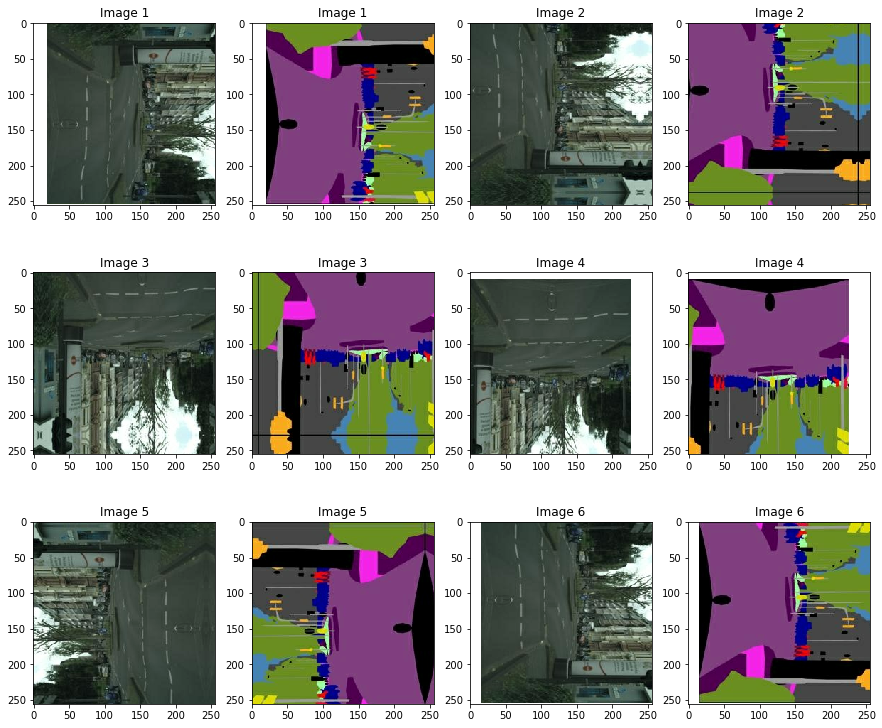

In [6]:
plt.figure(figsize=(15,13))
img_n = 1
for i in range(1, 13, 2):
    augmented_sketch, augmented_colored = apply_augmentation(sketch, colored)
    
    plt.subplot(3,4,i)
    plt.imshow(denormalize(augmented_sketch)); plt.title(f"Image {img_n}")
    plt.subplot(3,4,i+1); 
    plt.imshow(denormalize(augmented_colored)); plt.title(f"Image {img_n}")
    img_n += 1

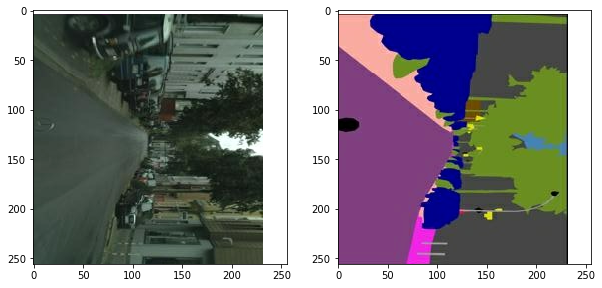

In [7]:
from tensorflow import data

def get_train(img_path):
    sketch, colored = load_img(img_path)
    sketch, colored = apply_augmentation(sketch, colored)
    return sketch, colored

train_images = data.Dataset.list_files(data_path + "*.jpg")
train_images = train_images.map(get_train).shuffle(100).batch(4)

sample = train_images.take(1)
sample = list(sample.as_numpy_iterator())
sketch, colored = (sample[0][0]+1)*127.5, (sample[0][1]+1)*127.5

plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(sketch[0].astype(np.uint8))
plt.subplot(1,2,2); plt.imshow(colored[0].astype(np.uint8))

## 2.Generator 구성하기

In [8]:
from tensorflow.keras import layers, Input, Model

class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu= layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

print("✅")

✅


In [9]:
class Encoder(layers.Layer):
    def __init__(self):
        super(Encoder, self).__init__()
        filters = [64,128,256,512,512,512,512,512]
        
        self.blocks = []
        for i, f in enumerate(filters):
            if i == 0:
                self.blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.blocks.append(EncodeBlock(f))
    
    def call(self, x):
        for block in self.blocks:
            x = block(x)
        return x
    
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

print("✅")

✅


In [10]:
Encoder().get_summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
encode_block (EncodeBlock)   (None, 128, 128, 64)      3072      
_________________________________________________________________
encode_block_1 (EncodeBlock) (None, 64, 64, 128)       131584    
_________________________________________________________________
encode_block_2 (EncodeBlock) (None, 32, 32, 256)       525312    
_________________________________________________________________
encode_block_3 (EncodeBlock) (None, 16, 16, 512)       2099200   
_________________________________________________________________
encode_block_4 (EncodeBlock) (None, 8, 8, 512)         4196352   
_________________________________________________________________
encode_block_5 (EncodeBlock) (None, 4, 4, 512)         419635

In [11]:
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)

    
class Decoder(layers.Layer):
    def __init__(self):
        super(Decoder, self).__init__()
        filters = [512,512,512,512,256,128,64]
        
        self.blocks = []
        for i, f in enumerate(filters):
            if i < 3:
                self.blocks.append(DecodeBlock(f))
            else:
                self.blocks.append(DecodeBlock(f, dropout=False))
                
        self.blocks.append(layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False))
        
    def call(self, x):
        for block in self.blocks:
            x = block(x)
        return x
            
    def get_summary(self, input_shape=(1,1,256)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()
        
print("✅")

✅


In [12]:
Decoder().get_summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 1, 1, 256)]       0         
_________________________________________________________________
decode_block (DecodeBlock)   (None, 2, 2, 512)         2099200   
_________________________________________________________________
decode_block_1 (DecodeBlock) (None, 4, 4, 512)         4196352   
_________________________________________________________________
decode_block_2 (DecodeBlock) (None, 8, 8, 512)         4196352   
_________________________________________________________________
decode_block_3 (DecodeBlock) (None, 16, 16, 512)       4196352   
_________________________________________________________________
decode_block_4 (DecodeBlock) (None, 32, 32, 256)       2098176   
_________________________________________________________________
decode_block_5 (DecodeBlock) (None, 64, 64, 128)       5248

In [13]:
class EncoderDecoderGenerator(Model):
    def __init__(self):
        super(EncoderDecoderGenerator, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
    
    def call(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
   
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()
        

EncoderDecoderGenerator().get_summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
encoder_1 (Encoder)          (None, 1, 1, 512)         19544576  
_________________________________________________________________
decoder_1 (Decoder)          (None, 256, 256, 3)       19542784  
Total params: 39,087,360
Trainable params: 39,076,480
Non-trainable params: 10,880
_________________________________________________________________


## 3. Generator 재구성

In [14]:
class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu = layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

    
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)
    
print("✅")

✅


In [15]:
class UNetGenerator(Model):
    def __init__(self):
        super(UNetGenerator, self).__init__()
        encode_filters = [64,128,256,512,512,512,512,512]
        decode_filters = [512,512,512,512,256,128,64]
        
        self.encode_blocks = []
        for i, f in enumerate(encode_filters):
            if i == 0:
                self.encode_blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.encode_blocks.append(EncodeBlock(f))
        
        self.decode_blocks = []
        for i, f in enumerate(decode_filters):
            if i < 3:
                self.decode_blocks.append(DecodeBlock(f))
            else:
                self.decode_blocks.append(DecodeBlock(f, dropout=False))
        
        self.last_conv = layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False)
    
    def call(self, x):
        features = []
        for block in self.encode_blocks:
            x = block(x)
            features.append(x)
        
        features = features[:-1]
                    
        for block, feat in zip(self.decode_blocks, features[::-1]):
            x = block(x)
            x = layers.Concatenate()([x, feat])
        
        x = self.last_conv(x)
        return x
                
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

print("✅")

✅


In [16]:
UNetGenerator().get_summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
encode_block_16 (EncodeBlock)   (None, 128, 128, 64) 3072        input_4[0][0]                    
__________________________________________________________________________________________________
encode_block_17 (EncodeBlock)   (None, 64, 64, 128)  131584      encode_block_16[0][0]            
__________________________________________________________________________________________________
encode_block_18 (EncodeBlock)   (None, 32, 32, 256)  525312      encode_block_17[0][0]            
____________________________________________________________________________________________

## 4. Discriminator 구성

In [17]:
class DiscBlock(layers.Layer):
    def __init__(self, n_filters, stride=2, custom_pad=False, use_bn=True, act=True):
        super(DiscBlock, self).__init__()
        self.custom_pad = custom_pad
        self.use_bn = use_bn
        self.act = act
        
        if custom_pad:
            self.padding = layers.ZeroPadding2D()
            self.conv = layers.Conv2D(n_filters, 4, stride, "valid", use_bias=False)
        else:
            self.conv = layers.Conv2D(n_filters, 4, stride, "same", use_bias=False)
        
        self.batchnorm = layers.BatchNormalization() if use_bn else None
        self.lrelu = layers.LeakyReLU(0.2) if act else None
        
    def call(self, x):
        if self.custom_pad:
            x = self.padding(x)
            x = self.conv(x)
        else:
            x = self.conv(x)
                
        if self.use_bn:
            x = self.batchnorm(x)
            
        if self.act:
            x = self.lrelu(x)
        return x 

print("✅")

✅


In [18]:
inputs = Input((128,128,32))
out = layers.ZeroPadding2D()(inputs)
out = layers.Conv2D(64, 4, 1, "valid", use_bias=False)(out)
out = layers.BatchNormalization()(out)
out = layers.LeakyReLU(0.2)(out)

Model(inputs, out).summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 128, 128, 32)]    0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 130, 130, 32)      0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 127, 127, 64)      32768     
_________________________________________________________________
batch_normalization_45 (Batc (None, 127, 127, 64)      256       
_________________________________________________________________
leaky_re_lu_24 (LeakyReLU)   (None, 127, 127, 64)      0         
Total params: 33,024
Trainable params: 32,896
Non-trainable params: 128
_________________________________________________________________


In [19]:
class Discriminator(Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.block1 = layers.Concatenate()
        self.block2 = DiscBlock(n_filters=64, stride=2, custom_pad=False, use_bn=False, act=True)
        self.block3 = DiscBlock(n_filters=128, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block4 = DiscBlock(n_filters=256, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block5 = DiscBlock(n_filters=512, stride=1, custom_pad=True, use_bn=True, act=True)
        self.block6 = DiscBlock(n_filters=1, stride=1, custom_pad=True, use_bn=False, act=False)
        self.sigmoid = layers.Activation("sigmoid")
        
        # filters = [64,128,256,512,1]
        # self.blocks = [layers.Concatenate()]
        # for i, f in enumerate(filters):
        #     self.blocks.append(DiscBlock(
        #         n_filters=f,
        #         strides=2 if i<3 else 1,
        #         custom_pad=False if i<3 else True,
        #         use_bn=False if i==0 and i==4 else True,
        #         act=True if i<4 else False
        #     ))
    
    def call(self, x, y):
        out = self.block1([x, y])
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        out = self.block5(out)
        out = self.block6(out)
        return self.sigmoid(out)
    
    def get_summary(self, x_shape=(256,256,3), y_shape=(256,256,3)):
        x, y = Input(x_shape), Input(y_shape) 
        return Model((x, y), self.call(x, y)).summary()
    
print("✅")

✅


In [20]:
Discriminator().get_summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
input_7 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
concatenate_7 (Concatenate)     (None, 256, 256, 6)  0           input_6[0][0]                    
                                                                 input_7[0][0]                    
__________________________________________________________________________________________________
disc_block (DiscBlock)          (None, 128, 128, 64) 6144        concatenate_7[0][0]        

## 5. 학습 및 테스트

In [21]:
from tensorflow.keras import losses

bce = losses.BinaryCrossentropy(from_logits=False)
mae = losses.MeanAbsoluteError()

def get_gene_loss(fake_output, real_output, fake_disc):
    l1_loss = mae(real_output, fake_output)
    gene_loss = bce(tf.ones_like(fake_disc), fake_disc)
    return gene_loss, l1_loss

def get_disc_loss(fake_disc, real_disc):
    return bce(tf.zeros_like(fake_disc), fake_disc) + bce(tf.ones_like(real_disc), real_disc)

print("✅")

✅


In [22]:
from tensorflow.keras import optimizers

gene_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)
disc_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)

print("✅")

✅


In [23]:
@tf.function
def train_step(sketch, real_colored):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        # Generator 예측
        fake_colored = generator(sketch, training=True)
        # Discriminator 예측
        fake_disc = discriminator(sketch, fake_colored, training=True)
        real_disc = discriminator(sketch, real_colored, training=True)
        # Generator 손실 계산
        gene_loss, l1_loss = get_gene_loss(fake_colored, real_colored, fake_disc)
        gene_total_loss = gene_loss + (100 * l1_loss) ## <===== L1 손실 반영 λ=100
        # Discrminator 손실 계산
        disc_loss = get_disc_loss(fake_disc, real_disc)
                
    gene_gradient = gene_tape.gradient(gene_total_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    return gene_loss, l1_loss, disc_loss

print("✅")

✅


In [24]:
EPOCHS = 35

generator = UNetGenerator()
discriminator = Discriminator()

for epoch in range(1, EPOCHS+1):
    for i, (sketch, colored) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(sketch, colored)
                
        # 10회 반복마다 손실을 출력합니다.
        if (i+1) % 10 == 0:
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \
                    \nGenerator_loss:{g_loss.numpy():.4f} \
                    \nL1_loss:{l1_loss.numpy():.4f} \
                    \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")

EPOCH[1] - STEP[10]                     
Generator_loss:0.8363                     
L1_loss:0.2972                     
Discriminator_loss:1.2533

EPOCH[1] - STEP[20]                     
Generator_loss:0.9823                     
L1_loss:0.3014                     
Discriminator_loss:1.2071

EPOCH[1] - STEP[30]                     
Generator_loss:1.0510                     
L1_loss:0.3013                     
Discriminator_loss:1.0769

EPOCH[1] - STEP[40]                     
Generator_loss:1.5507                     
L1_loss:0.2952                     
Discriminator_loss:0.7314

EPOCH[1] - STEP[50]                     
Generator_loss:1.5507                     
L1_loss:0.2344                     
Discriminator_loss:0.5012

EPOCH[1] - STEP[60]                     
Generator_loss:1.8939                     
L1_loss:0.2964                     
Discriminator_loss:0.9109

EPOCH[1] - STEP[70]                     
Generator_loss:1.9888                     
L1_loss:0.2466                    

EPOCH[3] - STEP[70]                     
Generator_loss:0.9746                     
L1_loss:0.2644                     
Discriminator_loss:1.0616

EPOCH[3] - STEP[80]                     
Generator_loss:1.4742                     
L1_loss:0.2078                     
Discriminator_loss:0.4246

EPOCH[3] - STEP[90]                     
Generator_loss:1.2294                     
L1_loss:0.2219                     
Discriminator_loss:0.7225

EPOCH[3] - STEP[100]                     
Generator_loss:0.8658                     
L1_loss:0.1798                     
Discriminator_loss:0.9897

EPOCH[3] - STEP[110]                     
Generator_loss:2.8534                     
L1_loss:0.1896                     
Discriminator_loss:0.4022

EPOCH[3] - STEP[120]                     
Generator_loss:1.6312                     
L1_loss:0.2087                     
Discriminator_loss:1.4066

EPOCH[3] - STEP[130]                     
Generator_loss:2.0382                     
L1_loss:0.2659                

EPOCH[5] - STEP[130]                     
Generator_loss:2.3908                     
L1_loss:0.2133                     
Discriminator_loss:0.8526

EPOCH[5] - STEP[140]                     
Generator_loss:2.2085                     
L1_loss:0.2037                     
Discriminator_loss:1.1781

EPOCH[5] - STEP[150]                     
Generator_loss:1.2811                     
L1_loss:0.2441                     
Discriminator_loss:0.8060

EPOCH[5] - STEP[160]                     
Generator_loss:1.1483                     
L1_loss:0.1759                     
Discriminator_loss:0.9505

EPOCH[5] - STEP[170]                     
Generator_loss:1.7070                     
L1_loss:0.2417                     
Discriminator_loss:0.7506

EPOCH[5] - STEP[180]                     
Generator_loss:1.3905                     
L1_loss:0.1659                     
Discriminator_loss:0.8241

EPOCH[5] - STEP[190]                     
Generator_loss:2.8268                     
L1_loss:0.1949             

EPOCH[7] - STEP[190]                     
Generator_loss:1.3686                     
L1_loss:0.1866                     
Discriminator_loss:0.4499

EPOCH[7] - STEP[200]                     
Generator_loss:2.0311                     
L1_loss:0.1647                     
Discriminator_loss:0.5423

EPOCH[7] - STEP[210]                     
Generator_loss:2.3654                     
L1_loss:0.1833                     
Discriminator_loss:0.5031

EPOCH[7] - STEP[220]                     
Generator_loss:2.7892                     
L1_loss:0.1765                     
Discriminator_loss:0.7083

EPOCH[7] - STEP[230]                     
Generator_loss:1.3075                     
L1_loss:0.1958                     
Discriminator_loss:0.5047

EPOCH[7] - STEP[240]                     
Generator_loss:2.1001                     
L1_loss:0.1988                     
Discriminator_loss:0.4735

EPOCH[7] - STEP[250]                     
Generator_loss:2.2476                     
L1_loss:0.1785             

EPOCH[9] - STEP[250]                     
Generator_loss:0.5756                     
L1_loss:0.1921                     
Discriminator_loss:1.1883

EPOCH[10] - STEP[10]                     
Generator_loss:1.4102                     
L1_loss:0.1852                     
Discriminator_loss:0.4064

EPOCH[10] - STEP[20]                     
Generator_loss:1.8654                     
L1_loss:0.1535                     
Discriminator_loss:1.2390

EPOCH[10] - STEP[30]                     
Generator_loss:0.5364                     
L1_loss:0.1850                     
Discriminator_loss:1.1830

EPOCH[10] - STEP[40]                     
Generator_loss:2.4359                     
L1_loss:0.1769                     
Discriminator_loss:0.6295

EPOCH[10] - STEP[50]                     
Generator_loss:2.7948                     
L1_loss:0.1493                     
Discriminator_loss:0.9669

EPOCH[10] - STEP[60]                     
Generator_loss:2.1516                     
L1_loss:0.1727             

EPOCH[12] - STEP[60]                     
Generator_loss:1.6582                     
L1_loss:0.1718                     
Discriminator_loss:0.6124

EPOCH[12] - STEP[70]                     
Generator_loss:1.6118                     
L1_loss:0.1958                     
Discriminator_loss:0.5485

EPOCH[12] - STEP[80]                     
Generator_loss:1.2995                     
L1_loss:0.2223                     
Discriminator_loss:0.4648

EPOCH[12] - STEP[90]                     
Generator_loss:1.6895                     
L1_loss:0.1937                     
Discriminator_loss:0.5611

EPOCH[12] - STEP[100]                     
Generator_loss:1.4707                     
L1_loss:0.1725                     
Discriminator_loss:0.5277

EPOCH[12] - STEP[110]                     
Generator_loss:3.2025                     
L1_loss:0.1415                     
Discriminator_loss:0.5900

EPOCH[12] - STEP[120]                     
Generator_loss:2.2390                     
L1_loss:0.1653          

EPOCH[14] - STEP[120]                     
Generator_loss:1.1855                     
L1_loss:0.1767                     
Discriminator_loss:1.1071

EPOCH[14] - STEP[130]                     
Generator_loss:3.0818                     
L1_loss:0.1512                     
Discriminator_loss:0.4643

EPOCH[14] - STEP[140]                     
Generator_loss:2.4794                     
L1_loss:0.1494                     
Discriminator_loss:1.7494

EPOCH[14] - STEP[150]                     
Generator_loss:0.4729                     
L1_loss:0.1350                     
Discriminator_loss:1.3297

EPOCH[14] - STEP[160]                     
Generator_loss:2.0543                     
L1_loss:0.1608                     
Discriminator_loss:0.3756

EPOCH[14] - STEP[170]                     
Generator_loss:1.7803                     
L1_loss:0.2067                     
Discriminator_loss:0.6284

EPOCH[14] - STEP[180]                     
Generator_loss:0.7895                     
L1_loss:0.1566      

EPOCH[16] - STEP[180]                     
Generator_loss:1.5752                     
L1_loss:0.1562                     
Discriminator_loss:0.6471

EPOCH[16] - STEP[190]                     
Generator_loss:1.8344                     
L1_loss:0.1760                     
Discriminator_loss:0.2986

EPOCH[16] - STEP[200]                     
Generator_loss:1.3103                     
L1_loss:0.1750                     
Discriminator_loss:0.7212

EPOCH[16] - STEP[210]                     
Generator_loss:2.0948                     
L1_loss:0.1621                     
Discriminator_loss:0.6467

EPOCH[16] - STEP[220]                     
Generator_loss:0.9571                     
L1_loss:0.1706                     
Discriminator_loss:0.8476

EPOCH[16] - STEP[230]                     
Generator_loss:3.3231                     
L1_loss:0.1766                     
Discriminator_loss:0.7634

EPOCH[16] - STEP[240]                     
Generator_loss:1.6340                     
L1_loss:0.1751      

EPOCH[18] - STEP[240]                     
Generator_loss:2.1816                     
L1_loss:0.1650                     
Discriminator_loss:0.3497

EPOCH[18] - STEP[250]                     
Generator_loss:1.6387                     
L1_loss:0.1742                     
Discriminator_loss:0.6658

EPOCH[19] - STEP[10]                     
Generator_loss:0.8087                     
L1_loss:0.1782                     
Discriminator_loss:1.0284

EPOCH[19] - STEP[20]                     
Generator_loss:1.4393                     
L1_loss:0.1633                     
Discriminator_loss:0.7404

EPOCH[19] - STEP[30]                     
Generator_loss:1.0997                     
L1_loss:0.1607                     
Discriminator_loss:0.6105

EPOCH[19] - STEP[40]                     
Generator_loss:1.2138                     
L1_loss:0.1624                     
Discriminator_loss:0.5631

EPOCH[19] - STEP[50]                     
Generator_loss:0.8928                     
L1_loss:0.1867           

EPOCH[21] - STEP[50]                     
Generator_loss:0.5713                     
L1_loss:0.1950                     
Discriminator_loss:1.0611

EPOCH[21] - STEP[60]                     
Generator_loss:1.1494                     
L1_loss:0.1943                     
Discriminator_loss:0.5897

EPOCH[21] - STEP[70]                     
Generator_loss:1.6003                     
L1_loss:0.1651                     
Discriminator_loss:0.3272

EPOCH[21] - STEP[80]                     
Generator_loss:2.5274                     
L1_loss:0.1486                     
Discriminator_loss:0.9600

EPOCH[21] - STEP[90]                     
Generator_loss:1.8703                     
L1_loss:0.1447                     
Discriminator_loss:0.8788

EPOCH[21] - STEP[100]                     
Generator_loss:0.9812                     
L1_loss:0.1793                     
Discriminator_loss:0.6771

EPOCH[21] - STEP[110]                     
Generator_loss:2.3359                     
L1_loss:0.1540           

EPOCH[23] - STEP[110]                     
Generator_loss:2.0842                     
L1_loss:0.1559                     
Discriminator_loss:0.7762

EPOCH[23] - STEP[120]                     
Generator_loss:2.2894                     
L1_loss:0.1448                     
Discriminator_loss:1.1011

EPOCH[23] - STEP[130]                     
Generator_loss:1.5353                     
L1_loss:0.1575                     
Discriminator_loss:0.6509

EPOCH[23] - STEP[140]                     
Generator_loss:3.5016                     
L1_loss:0.1940                     
Discriminator_loss:0.0821

EPOCH[23] - STEP[150]                     
Generator_loss:2.2428                     
L1_loss:0.1675                     
Discriminator_loss:0.2664

EPOCH[23] - STEP[160]                     
Generator_loss:2.1447                     
L1_loss:0.1552                     
Discriminator_loss:0.8172

EPOCH[23] - STEP[170]                     
Generator_loss:1.5569                     
L1_loss:0.1574      

EPOCH[25] - STEP[170]                     
Generator_loss:3.4945                     
L1_loss:0.1798                     
Discriminator_loss:0.2141

EPOCH[25] - STEP[180]                     
Generator_loss:1.5495                     
L1_loss:0.1912                     
Discriminator_loss:0.6638

EPOCH[25] - STEP[190]                     
Generator_loss:0.9159                     
L1_loss:0.1619                     
Discriminator_loss:0.7031

EPOCH[25] - STEP[200]                     
Generator_loss:2.3215                     
L1_loss:0.1644                     
Discriminator_loss:0.2133

EPOCH[25] - STEP[210]                     
Generator_loss:2.9591                     
L1_loss:0.1385                     
Discriminator_loss:1.3730

EPOCH[25] - STEP[220]                     
Generator_loss:3.2015                     
L1_loss:0.1668                     
Discriminator_loss:1.1648

EPOCH[25] - STEP[230]                     
Generator_loss:2.7307                     
L1_loss:0.1657      

EPOCH[27] - STEP[230]                     
Generator_loss:3.0117                     
L1_loss:0.2335                     
Discriminator_loss:0.2199

EPOCH[27] - STEP[240]                     
Generator_loss:2.9767                     
L1_loss:0.1758                     
Discriminator_loss:0.2903

EPOCH[27] - STEP[250]                     
Generator_loss:1.1924                     
L1_loss:0.1408                     
Discriminator_loss:0.8838

EPOCH[28] - STEP[10]                     
Generator_loss:2.3135                     
L1_loss:0.1696                     
Discriminator_loss:0.5796

EPOCH[28] - STEP[20]                     
Generator_loss:1.7230                     
L1_loss:0.1638                     
Discriminator_loss:0.9835

EPOCH[28] - STEP[30]                     
Generator_loss:1.8810                     
L1_loss:0.1829                     
Discriminator_loss:0.8443

EPOCH[28] - STEP[40]                     
Generator_loss:1.3024                     
L1_loss:0.1600          

EPOCH[30] - STEP[40]                     
Generator_loss:2.6877                     
L1_loss:0.1679                     
Discriminator_loss:0.3403

EPOCH[30] - STEP[50]                     
Generator_loss:2.5883                     
L1_loss:0.2014                     
Discriminator_loss:0.1845

EPOCH[30] - STEP[60]                     
Generator_loss:3.2970                     
L1_loss:0.1724                     
Discriminator_loss:0.4000

EPOCH[30] - STEP[70]                     
Generator_loss:1.5076                     
L1_loss:0.1322                     
Discriminator_loss:1.4872

EPOCH[30] - STEP[80]                     
Generator_loss:2.6091                     
L1_loss:0.1754                     
Discriminator_loss:0.3493

EPOCH[30] - STEP[90]                     
Generator_loss:3.6577                     
L1_loss:0.1433                     
Discriminator_loss:1.3675

EPOCH[30] - STEP[100]                     
Generator_loss:3.6920                     
L1_loss:0.1751            

EPOCH[32] - STEP[100]                     
Generator_loss:1.8268                     
L1_loss:0.1666                     
Discriminator_loss:0.4615

EPOCH[32] - STEP[110]                     
Generator_loss:2.8379                     
L1_loss:0.1479                     
Discriminator_loss:0.5732

EPOCH[32] - STEP[120]                     
Generator_loss:1.7235                     
L1_loss:0.1545                     
Discriminator_loss:0.5078

EPOCH[32] - STEP[130]                     
Generator_loss:2.9018                     
L1_loss:0.1598                     
Discriminator_loss:0.5177

EPOCH[32] - STEP[140]                     
Generator_loss:2.4121                     
L1_loss:0.1446                     
Discriminator_loss:0.9224

EPOCH[32] - STEP[150]                     
Generator_loss:0.9674                     
L1_loss:0.1662                     
Discriminator_loss:0.6499

EPOCH[32] - STEP[160]                     
Generator_loss:2.5659                     
L1_loss:0.1239      

EPOCH[34] - STEP[160]                     
Generator_loss:2.2122                     
L1_loss:0.1259                     
Discriminator_loss:0.4893

EPOCH[34] - STEP[170]                     
Generator_loss:3.2234                     
L1_loss:0.1543                     
Discriminator_loss:1.1021

EPOCH[34] - STEP[180]                     
Generator_loss:2.1150                     
L1_loss:0.1400                     
Discriminator_loss:0.5993

EPOCH[34] - STEP[190]                     
Generator_loss:3.3070                     
L1_loss:0.1915                     
Discriminator_loss:0.5120

EPOCH[34] - STEP[200]                     
Generator_loss:2.8651                     
L1_loss:0.1346                     
Discriminator_loss:0.3218

EPOCH[34] - STEP[210]                     
Generator_loss:2.8558                     
L1_loss:0.1096                     
Discriminator_loss:1.3065

EPOCH[34] - STEP[220]                     
Generator_loss:2.1695                     
L1_loss:0.1601      

Text(0.5, 1.0, 'sketch')

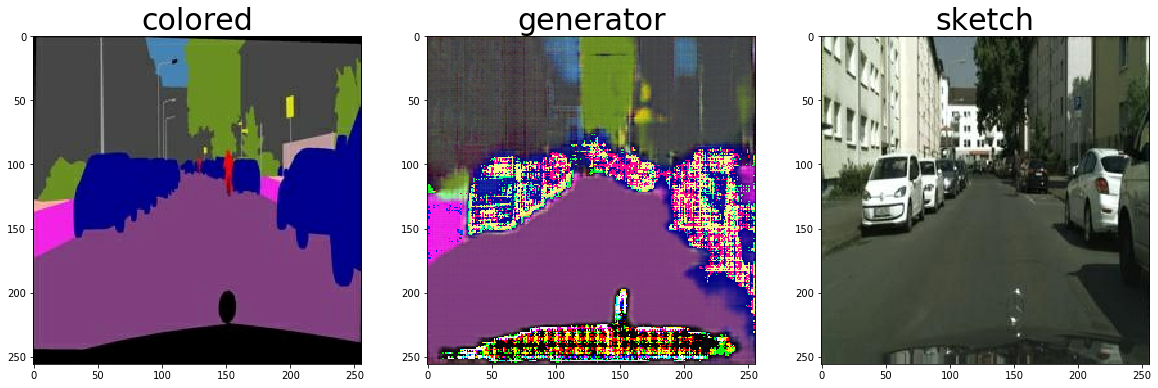

In [27]:
test_ind = 1

test_data_path = data_path = os.getenv('HOME')+'/aiffel/conditional_generation/cityscapes/val/'

f = test_data_path + os.listdir(test_data_path)[test_ind]
sketch, colored = load_img(f)

pred = generator(tf.expand_dims(sketch, 0))
pred = denormalize(pred)

plt.figure(figsize=(20,10))
plt.subplot(1,3,1); plt.imshow(denormalize(colored)) ; plt.title('colored', fontsize = 30)
plt.subplot(1,3,2); plt.imshow(pred[0]) ; plt.title('generator', fontsize = 30)
plt.subplot(1,3,3); plt.imshow(denormalize(sketch)); plt.title('sketch', fontsize = 30)